In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d sukhmandeepsinghbrar/daily-delhi-climate

Dataset URL: https://www.kaggle.com/datasets/sukhmandeepsinghbrar/daily-delhi-climate
License(s): CC0-1.0
daily-delhi-climate.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/daily-delhi-climate.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv("/content/DailyDelhiClimate.csv")
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1576 non-null   object 
 1   meantemp      1576 non-null   float64
 2   humidity      1576 non-null   float64
 3   wind_speed    1576 non-null   float64
 4   meanpressure  1576 non-null   float64
dtypes: float64(4), object(1)
memory usage: 61.7+ KB


In [7]:
df.shape

(1576, 5)

In [8]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [9]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


In [10]:
df.isnull().sum()

,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [11]:
duplicates = df.index[df.index.duplicated()]
print(duplicates)

DatetimeIndex(['2017-01-01'], dtype='datetime64[ns]', name='date', freq=None)


In [12]:
df = df[~df.index.duplicated(keep='first')]

In [13]:
duplicates = df.index[df.index.duplicated()]
print(duplicates)

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


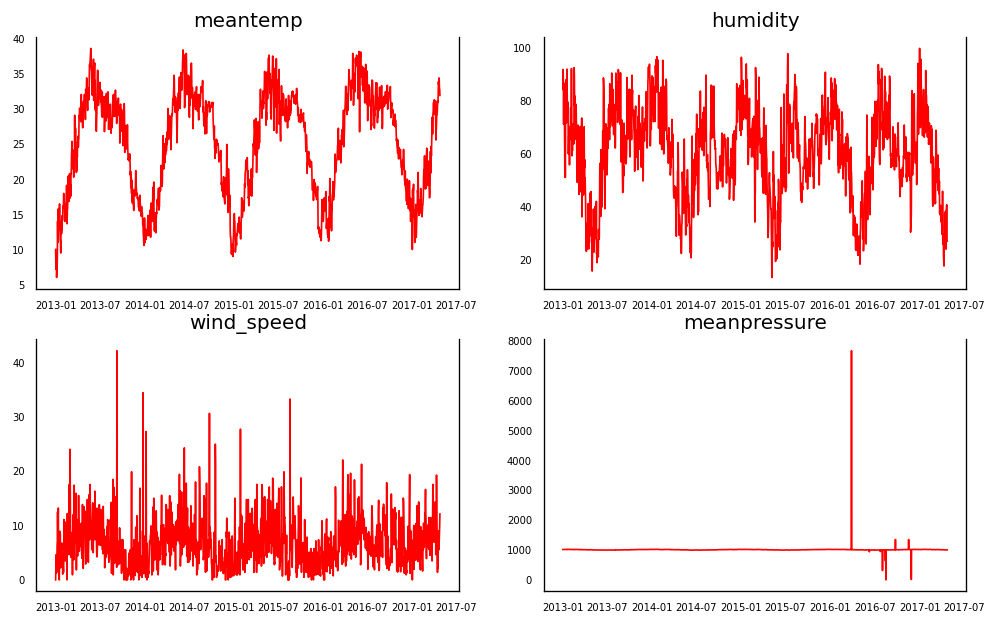

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [15]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name=''):
    """
    Perform the Augmented Dickey-Fuller test on a time series.

    Parameters:
    - series: Time series to test
    - signif: Significance level for the test (default: 0.05)
    - name: Name of the series being tested

    Prints:
    - Test statistic
    - p-value
    - Number of lags used
    - Number of observations used
    - Whether the series is stationary or not
    """
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    print(f'Results of Dickey-Fuller Test for {name}:')
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')

    if result[1] <= signif:
        print(f"The series '{name}' is likely stationary.")
    else:
        print(f"The series '{name}' is likely non-stationary.")

# Applying the function to each column
for column in df.columns:
    adfuller_test(df[column], name=column)
    print("\n")


Results of Dickey-Fuller Test for meantemp:
ADF Test Statistic: -2.3775922788686077
p-value: 0.14816094871135538
#Lags Used: 10
Number of Observations Used: 1564
The series 'meantemp' is likely non-stationary.


Results of Dickey-Fuller Test for humidity:
ADF Test Statistic: -3.634319111053002
p-value: 0.005137816812132598
#Lags Used: 15
Number of Observations Used: 1559
The series 'humidity' is likely stationary.


Results of Dickey-Fuller Test for wind_speed:
ADF Test Statistic: -4.005166804036911
p-value: 0.0013836966935457308
#Lags Used: 24
Number of Observations Used: 1550
The series 'wind_speed' is likely stationary.


Results of Dickey-Fuller Test for meanpressure:
ADF Test Statistic: -39.522690682164544
p-value: 0.0
#Lags Used: 0
Number of Observations Used: 1574
The series 'meanpressure' is likely stationary.




In [16]:
df['meantemp_diff'] = df['meantemp'].diff()
df = df.dropna()

# Perform ADF test on the differenced series
adfuller_test(df['meantemp_diff'], name='meantemp_diff')

# Create DataFrame with 'meantemp_diff'
df_with_diff = df[['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_diff']].copy()

# Create DataFrame without 'meantemp_diff'
df = df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].copy()

# Output DataFrames for verification
print("DataFrame with 'meantemp_diff':")
print(df_with_diff.head())

print("\nDataFrame without 'meantemp_diff':")
print(df.head())

Results of Dickey-Fuller Test for meantemp_diff:
ADF Test Statistic: -16.919263167679727
p-value: 9.968999414142703e-30
#Lags Used: 9
Number of Observations Used: 1564
The series 'meantemp_diff' is likely stationary.
DataFrame with 'meantemp_diff':
            meantemp   humidity  wind_speed  meanpressure  meantemp_diff
date                                                                    
2013-01-02  7.400000  92.000000    2.980000   1017.800000      -2.600000
2013-01-03  7.166667  87.000000    4.633333   1018.666667      -0.233333
2013-01-04  8.666667  71.333333    1.233333   1017.166667       1.500000
2013-01-05  6.000000  86.833333    3.700000   1016.500000      -2.666667
2013-01-06  7.000000  82.800000    1.480000   1018.000000       1.000000

DataFrame without 'meantemp_diff':
            meantemp   humidity  wind_speed  meanpressure
date                                                     
2013-01-02  7.400000  92.000000    2.980000   1017.800000
2013-01-03  7.166667  87.00000

In [17]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
2013-01-06,7.000000,82.800000,1.480000,1018.000000


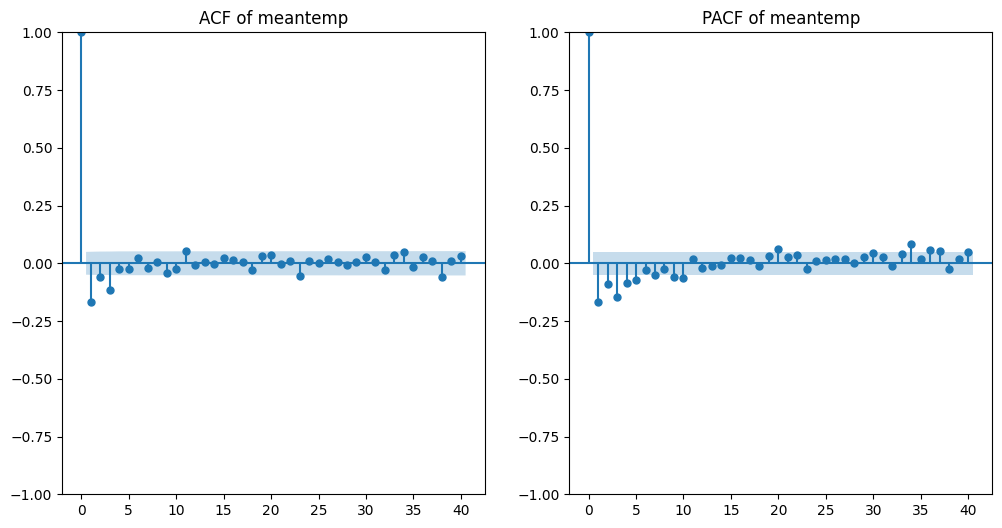

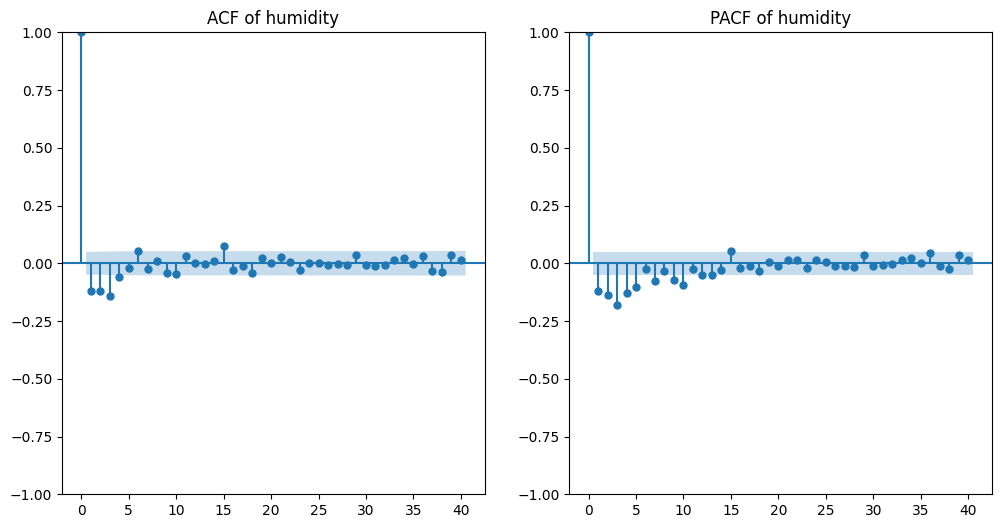

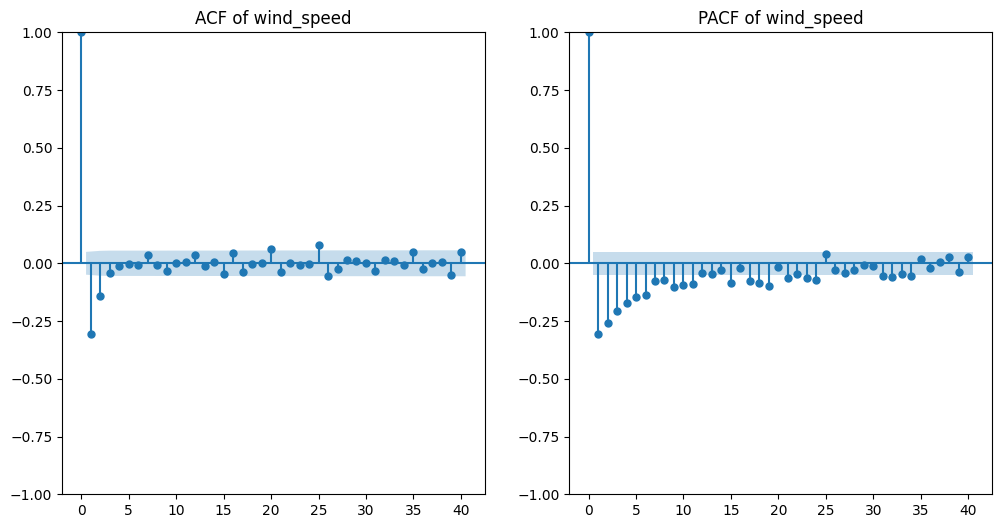

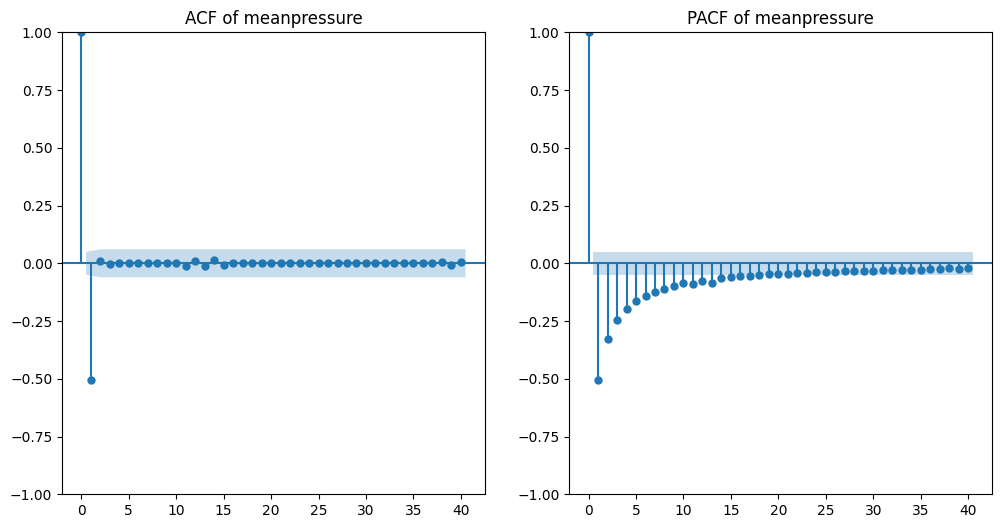

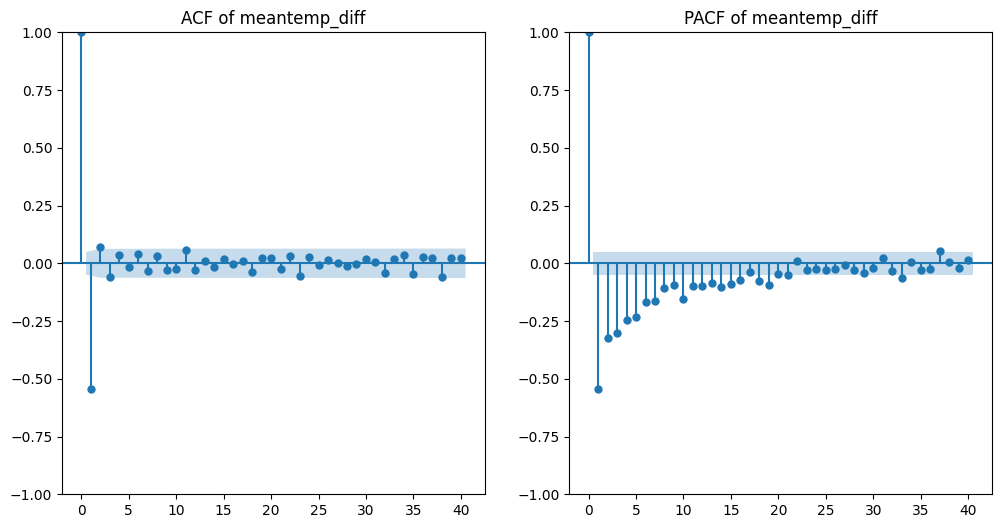

In [18]:
for column in df_with_diff.columns:
    plt.figure(figsize=(12, 6))

    # Plot ACF
    plt.subplot(121)
    plot_acf(df_with_diff[column].diff().dropna(), lags=40, ax=plt.gca())
    plt.title(f'ACF of {column}')

    # Plot PACF
    plt.subplot(122)
    plot_pacf(df_with_diff[column].diff().dropna(), lags=40, ax=plt.gca())
    plt.title(f'PACF of {column}')

    plt.show()

In [19]:
from itertools import combinations
from statsmodels.tsa.stattools import grangercausalitytests

# Function to perform Granger Causality test for all pairs
def granger_causality_tests(df_with_diff, maxlag=4):
    columns = df_with_diff.columns
    for (col1, col2) in combinations(columns, 2):
        print(f'\n{col2} causes {col1}?\n')
        print('------------------')
        granger_result_1 = grangercausalitytests(df_with_diff[[col1, col2]], maxlag)

        print(f'\n{col1} causes {col2}?\n')
        print('------------------')
        granger_result_2 = grangercausalitytests(df_with_diff[[col2, col1]], maxlag)

df_stationary = df.drop(columns=['meantemp'])
granger_causality_tests(df_stationary)


wind_speed causes humidity?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6247  , p=0.4294  , df_denom=1570, df_num=1
ssr based chi2 test:   chi2=0.6259  , p=0.4288  , df=1
likelihood ratio test: chi2=0.6258  , p=0.4289  , df=1
parameter F test:         F=0.6247  , p=0.4294  , df_denom=1570, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3486  , p=0.7057  , df_denom=1567, df_num=2
ssr based chi2 test:   chi2=0.6994  , p=0.7049  , df=2
likelihood ratio test: chi2=0.6993  , p=0.7049  , df=2
parameter F test:         F=0.3486  , p=0.7057  , df_denom=1567, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1582  , p=0.9244  , df_denom=1564, df_num=3
ssr based chi2 test:   chi2=0.4766  , p=0.9240  , df=3
likelihood ratio test: chi2=0.4765  , p=0.9240  , df=3
parameter F test:         F=0.1582  , p=0.9244  , df_denom=1564, df_num=3

Granger Causality
number of lags (no z

In [20]:
df.shape


(1574, 4)

In [21]:
train_df=df[:-320]
test_df=df[-320:]
print(train_df.shape)
print(test_df.shape)
print(train_df.tail())
print(test_df.head())


(1254, 4)
(320, 4)
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2016-06-04  38.200000  42.066667    3.206667   1001.866667
2016-06-05  36.166667  51.750000    8.500000   1002.833333
2016-06-06  35.428571  45.714286   11.000000   1001.571429
2016-06-07  34.625000  59.187500   21.306250   1002.062500
2016-06-08  36.071429  44.642857    8.485714    999.214286
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2016-06-09  35.733333  43.733333     9.26000    938.066667
2016-06-10  36.133333  41.866667    10.08125    998.250000
2016-06-11  33.437500  49.937500     8.81250    999.000000
2016-06-12  35.500000  37.125000     9.16250    998.812500
2016-06-13  36.000000  43.312500    12.85000    998.187500


#Vector Autoregression (VAR)
**Theory**: Combines VAR with MA components. Models the relationship between multiple time series with both autoregressive and moving average terms.

**Equation**: Extends VAR by including MA terms in the model:
$$\mathbf{X}_t = c + \mathbf{A}_1 \mathbf{X}_{t-1} + \cdots + \mathbf{A}_p \mathbf{X}_{t-p} + \mathbf{\epsilon}_t$$

**Parameters:**

- **$\mathbf{A}_i$**: Coefficient matrices for the autoregressive terms  
- **$p$**: Number of lags
- **$c$**: Vector of constants (intercept terms).

In [22]:

model = VAR(train_df.diff()[1:])

In [23]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        19.09       19.11   1.951e+08       19.10
1        18.66       18.74   1.270e+08       18.69
2        18.40       18.55   9.833e+07       18.46
3        18.24       18.45   8.334e+07       18.32
4        18.17      18.45*   7.774e+07       18.27
5        18.12       18.47   7.408e+07       18.25
6        18.09       18.51   7.191e+07      18.25*
7        18.07       18.55   7.060e+07       18.25
8        18.07       18.62   7.064e+07       18.28
9        18.06       18.67   6.959e+07       18.29
10       18.04       18.73   6.868e+07       18.30
11      18.04*       18.79  6.829e+07*       18.32
12       18.05       18.87   6.920e+07       18.36
13       18.06       18.94   6.955e+07       18.39
14       18.06       19.01   6.995e+07       18.42
15       18.06       19.07   6.967e+07       18.44
16       18.07       19.15   7.

In [24]:
var_model = VARMAX(train_df, order=(11,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                             Statespace Model Results                                             
Dep. Variable:     ['meantemp', 'humidity', 'wind_speed', 'meanpressure']   No. Observations:                 1254
Model:                                                            VAR(11)   Log Likelihood              -18160.394
                                                              + intercept   AIC                          36700.788
Date:                                                    Mon, 12 Aug 2024   BIC                          37676.266
Time:                                                            04:43:27   HQIC                         37067.445
Sample:                                                        01-02-2013                                         
                                                             - 06-08-2016                                         
Covariance Type:                                                      opg       

In [25]:
# Predict on the test data
forecast_steps = len(test_df)
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_df = forecast.predicted_mean
# Align the forecast with the test data index
forecast_df.index = test_df.index

# Print the forecasted values
print("\nForecasted Values:")
print(forecast_df.head())


Forecasted Values:
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2016-06-09  35.328431  47.488615   10.003665    984.672333
2016-06-10  34.768825  50.054704    8.821654    940.664925
2016-06-11  34.371865  52.836126    8.044106    988.436824
2016-06-12  34.627465  52.279226    8.455117   1038.751471
2016-06-13  34.846205  49.858094    8.615800   1055.079132



Combined DataFrame (Actual vs Forecast):
               Actual                                      Forecast  \
             meantemp   humidity wind_speed meanpressure   meantemp   
date                                                                  
2016-06-09  35.733333  43.733333    9.26000   938.066667  35.328431   
2016-06-10  36.133333  41.866667   10.08125   998.250000  34.768825   
2016-06-11  33.437500  49.937500    8.81250   999.000000  34.371865   
2016-06-12  35.500000  37.125000    9.16250   998.812500  34.627465   
2016-06-13  36.000000  43.312500   12.85000   998.187500  34.846205   

                                               
             humidity wind_speed meanpressure  
date                                           
2016-06-09  47.488615  10.003665   984.672333  
2016-06-10  50.054704   8.821654   940.664925  
2016-06-11  52.836126   8.044106   988.436824  
2016-06-12  52.279226   8.455117  1038.751471  
2016-06-13  49.858094   8.615800  1055.079132  


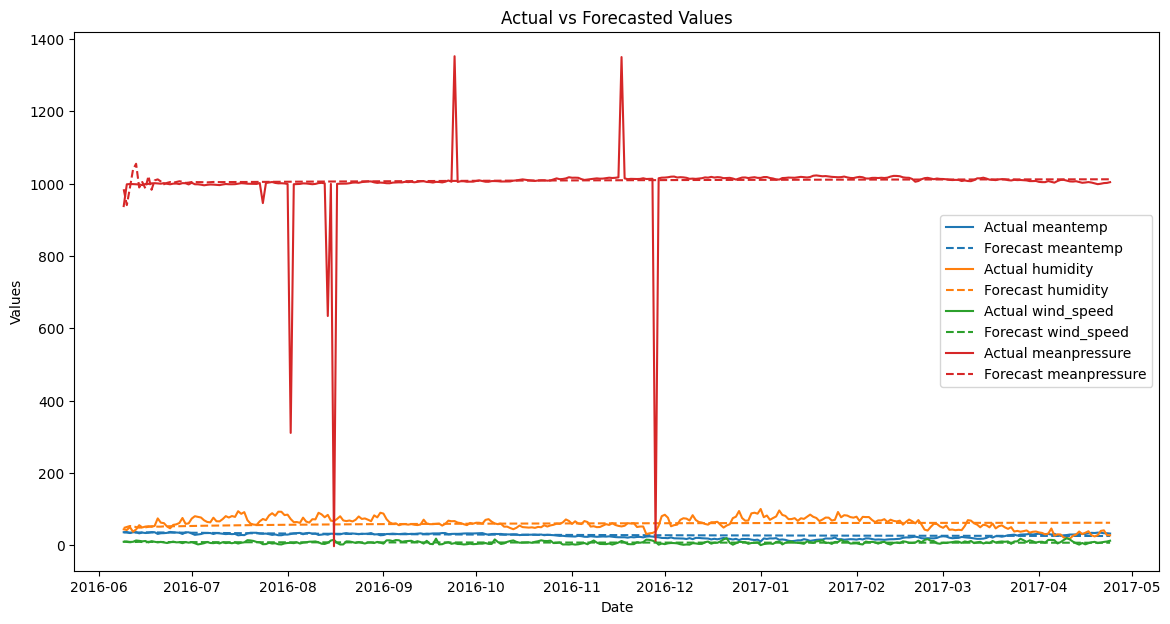

In [26]:
import matplotlib.pyplot as plt

# Combine actual and forecasted values for comparison
combined_df = pd.concat([test_df, forecast_df], axis=1, keys=['Actual', 'Forecast'])

# Print combined DataFrame for verification
print("\nCombined DataFrame (Actual vs Forecast):")
print(combined_df.head())

# Define colors for each variable
colors = plt.cm.tab10.colors  # Use a colormap for distinct colors

# Optional: Plot the actual vs forecasted values with different colors
plt.figure(figsize=(14, 7))
for i, column in enumerate(train_df.columns):
    # Plot Actual values
    plt.plot(test_df.index, test_df[column], label=f'Actual {column}', color=colors[i])

    # Plot Forecast values
    plt.plot(forecast_df.index, forecast_df[column], label=f'Forecast {column}', color=colors[i], linestyle='--')

plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


In [27]:
# Calculate RMSE for each column
rmse_values = {}
for column in test_df.columns:
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(test_df[column], forecast_df[column]))
    rmse_values[column] = rmse

# Print RMSE values for each column
print("RMSE values for each variable:")
for column, rmse in rmse_values.items():
    print(f'{column}: {rmse:.4f}')



RMSE values for each variable:
meantemp: 5.9562
humidity: 16.6025
wind_speed: 3.7336
meanpressure: 95.0993


In [28]:
future_steps = 12

# Forecast future values
future_forecast = fitted_model.get_forecast(steps=future_steps)
future_forecast_df = future_forecast.predicted_mean
future_forecast_df
# Create future dates
future_dates = pd.date_range(start=test_df.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
future_forecast_df.index = future_dates

# Print the future forecasted values
print("\nFuture Forecasted Values:")
print(future_forecast_df)


Future Forecasted Values:
             meantemp   humidity  wind_speed  meanpressure
2017-04-25  35.328431  47.488615   10.003665    984.672333
2017-04-26  34.768825  50.054704    8.821654    940.664925
2017-04-27  34.371865  52.836126    8.044106    988.436824
2017-04-28  34.627465  52.279226    8.455117   1038.751471
2017-04-29  34.846205  49.858094    8.615800   1055.079132
2017-04-30  35.205031  48.336556    9.166730    989.490786
2017-05-01  35.162171  48.923101    8.521068   1004.595536
2017-05-02  35.367776  49.247721    7.537081    986.829344
2017-05-03  35.285704  50.532374    9.192138   1020.915006
2017-05-04  35.065634  52.334991    8.840508    983.163975
2017-05-05  34.992026  51.761006    8.667360   1009.119468
2017-05-06  34.922481  51.117441    8.627053   1011.973166


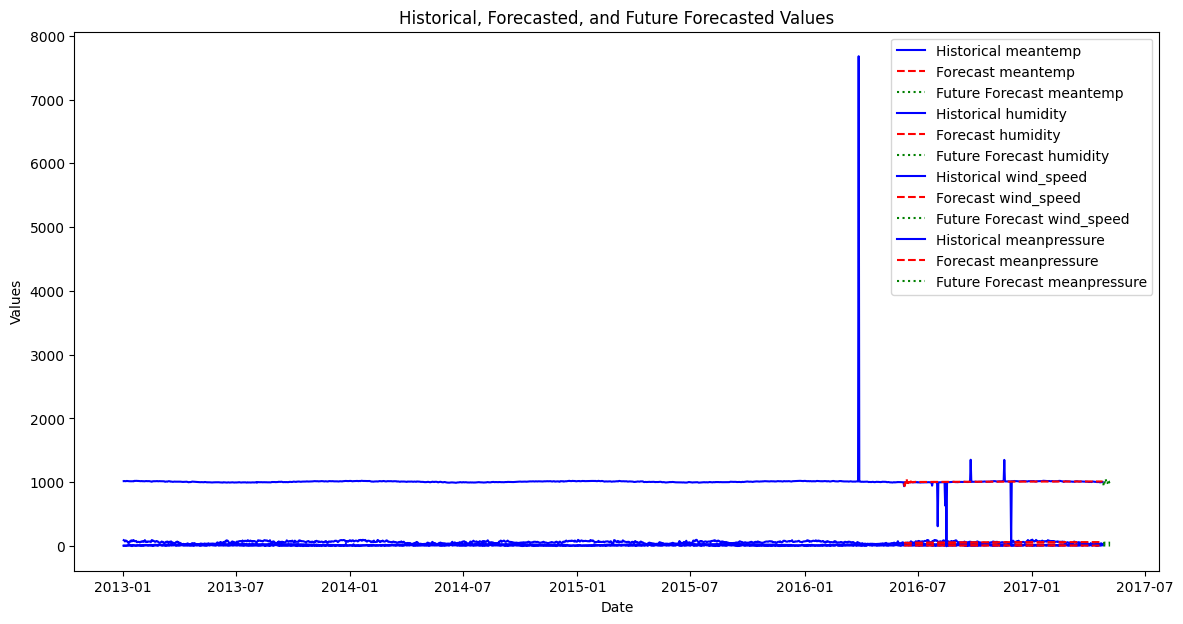

In [29]:

# Optional: Plot future forecasts
plt.figure(figsize=(14, 7))
for column in train_df.columns:
    plt.plot(df.index, df[column], label=f'Historical {column}', color='blue')
    plt.plot(forecast_df.index, forecast_df[column], label=f'Forecast {column}', color='red', linestyle='--')
    plt.plot(future_forecast_df.index, future_forecast_df[column], label=f'Future Forecast {column}', color='green', linestyle=':')

plt.title('Historical, Forecasted, and Future Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

#Vector Autoregression Moving Average (VARMA)
**Theory**: Combines VAR with MA components. Models the relationship between multiple time series with both autoregressive and moving average terms.

**Equation**: Extends VAR by including MA terms in the model:
$$\mathbf{X}_t = \mathbf{c} + \mathbf{A}_1 \mathbf{X}_{t-1} + \cdots + \mathbf{A}_p \mathbf{X}_{t-p} + \mathbf{B}_1 \mathbf{\epsilon}_{t-1} + \cdots + \mathbf{B}_q \mathbf{\epsilon}_{t-q}$$

**Parameters:**

- **$\mathbf{A}_i$**: AR coefficient matrices  
- **$\mathbf{B}_i$**: MA coefficient matrices  
- **$p$**: AR order  
- **$q$**: MA order


In [30]:
# from statsmodels.tsa.statespace.varmax import VARMAX
# import pandas as pd

# # Prepare differenced data
# diff_train_df = train_df.diff().dropna()
# q_values = range(0, 6)
# optimal_p = 11
# # Initialize lists to store results
# results = []

# for q in q_values:
#     try:
#         # Fit VARMA model with specified p and q
#         model = VARMAX(diff_train_df, order=(optimal_p, q))
#         fitted_model = model.fit(disp=False)

#         # Calculate AIC and BIC for model evaluation
#         aic = fitted_model.aic
#         bic = fitted_model.bic

#         # Append results
#         results.append((optimal_p, q, aic, bic))

#     except Exception as e:
#         print(f"Error with (p={optimal_p}, q={q}): {e}")
#         continue

# # Create a DataFrame with the results
# results_df = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'BIC'])
# print(results_df)


In [31]:
varma_model = VARMAX(train_df, order=(11,4),enforce_stationarity= True)
varma_fitted_model = varma_model.fit(disp=False)
print(fitted_model.summary())


                                             Statespace Model Results                                             
Dep. Variable:     ['meantemp', 'humidity', 'wind_speed', 'meanpressure']   No. Observations:                 1254
Model:                                                            VAR(11)   Log Likelihood              -18160.394
                                                              + intercept   AIC                          36700.788
Date:                                                    Mon, 12 Aug 2024   BIC                          37676.266
Time:                                                            04:53:03   HQIC                         37067.445
Sample:                                                        01-02-2013                                         
                                                             - 06-08-2016                                         
Covariance Type:                                                      opg       

In [32]:
# Predict on the test data
forecast_steps = len(test_df)
forecast = varma_fitted_model.get_forecast(steps=forecast_steps)
forecast_df_varma = forecast.predicted_mean
# Align the forecast with the test data index
forecast_df_varma.index = test_df.index

# Print the forecasted values
print("\nForecasted Values:")
print(forecast_df_varma.head())


Forecasted Values:
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2016-06-09  35.339919  47.281503    9.973333    986.407201
2016-06-10  34.800701  49.782614    8.942546    940.835204
2016-06-11  34.422753  52.337060    8.040521    987.690722
2016-06-12  34.715078  52.014103    8.487965   1041.232547
2016-06-13  34.860226  49.970398    8.591894   1056.173242



Combined DataFrame (Actual vs Forecast):
               Actual                                      Forecast  \
             meantemp   humidity wind_speed meanpressure   meantemp   
date                                                                  
2016-06-09  35.733333  43.733333    9.26000   938.066667  35.339919   
2016-06-10  36.133333  41.866667   10.08125   998.250000  34.800701   
2016-06-11  33.437500  49.937500    8.81250   999.000000  34.422753   
2016-06-12  35.500000  37.125000    9.16250   998.812500  34.715078   
2016-06-13  36.000000  43.312500   12.85000   998.187500  34.860226   

                                               
             humidity wind_speed meanpressure  
date                                           
2016-06-09  47.281503   9.973333   986.407201  
2016-06-10  49.782614   8.942546   940.835204  
2016-06-11  52.337060   8.040521   987.690722  
2016-06-12  52.014103   8.487965  1041.232547  
2016-06-13  49.970398   8.591894  1056.173242  


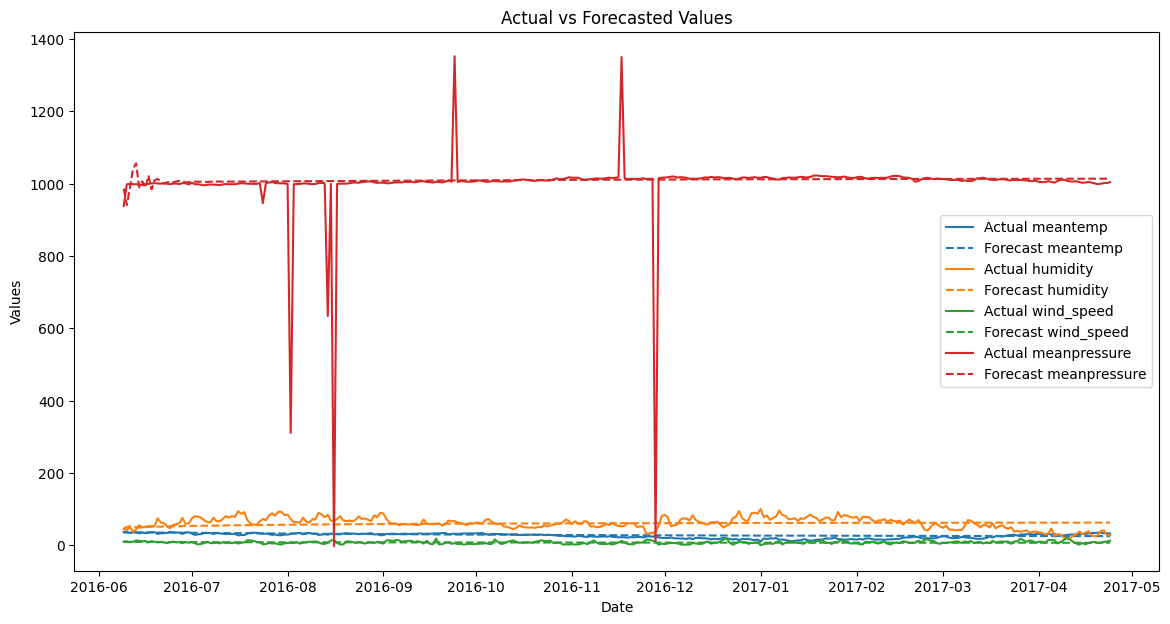

In [33]:
import matplotlib.pyplot as plt

# Combine actual and forecasted values for comparison
combined_df = pd.concat([test_df, forecast_df_varma], axis=1, keys=['Actual', 'Forecast'])

# Print combined DataFrame for verification
print("\nCombined DataFrame (Actual vs Forecast):")
print(combined_df.head())

# Define colors for each variable
colors = plt.cm.tab10.colors  # Use a colormap for distinct colors

# Optional: Plot the actual vs forecasted values with different colors
plt.figure(figsize=(14, 7))
for i, column in enumerate(train_df.columns):
    # Plot Actual values
    plt.plot(test_df.index, test_df[column], label=f'Actual {column}', color=colors[i])

    # Plot Forecast values
    plt.plot(forecast_df_varma.index, forecast_df_varma[column], label=f'Forecast {column}', color=colors[i], linestyle='--')

plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


In [34]:
# Calculate RMSE for each column
rmse_values = {}
for column in test_df.columns:
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(test_df[column], forecast_df_varma[column]))
    rmse_values[column] = rmse

# Print RMSE values for each column
print("RMSE values for each variable:")
for column, rmse in rmse_values.items():
    print(f'{column}: {rmse:.4f}')



RMSE values for each variable:
meantemp: 5.8295
humidity: 16.6117
wind_speed: 3.7462
meanpressure: 95.2229


In [35]:
future_steps = 12

# Forecast future values
future_forecast = varma_fitted_model.get_forecast(steps=future_steps)
future_forecast_df = future_forecast.predicted_mean
future_forecast_df
# Create future dates
future_dates = pd.date_range(start=test_df.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
future_forecast_df.index = future_dates

# Print the future forecasted values
print("\nFuture Forecasted Values:")
print(future_forecast_df)


Future Forecasted Values:
             meantemp   humidity  wind_speed  meanpressure
2017-04-25  35.339919  47.281503    9.973333    986.407201
2017-04-26  34.800701  49.782614    8.942546    940.835204
2017-04-27  34.422753  52.337060    8.040521    987.690722
2017-04-28  34.715078  52.014103    8.487965   1041.232547
2017-04-29  34.860226  49.970398    8.591894   1056.173242
2017-04-30  35.247782  48.320796    9.169643    990.258166
2017-05-01  35.161619  49.113920    8.542449   1006.406479
2017-05-02  35.369636  49.330800    7.473633    988.536720
2017-05-03  35.277877  50.581100    9.160159   1022.867965
2017-05-04  35.065063  52.359437    8.796310    984.071302
2017-05-05  34.992976  51.803589    8.645835   1009.687921
2017-05-06  34.923748  51.166710    8.607879   1013.100132


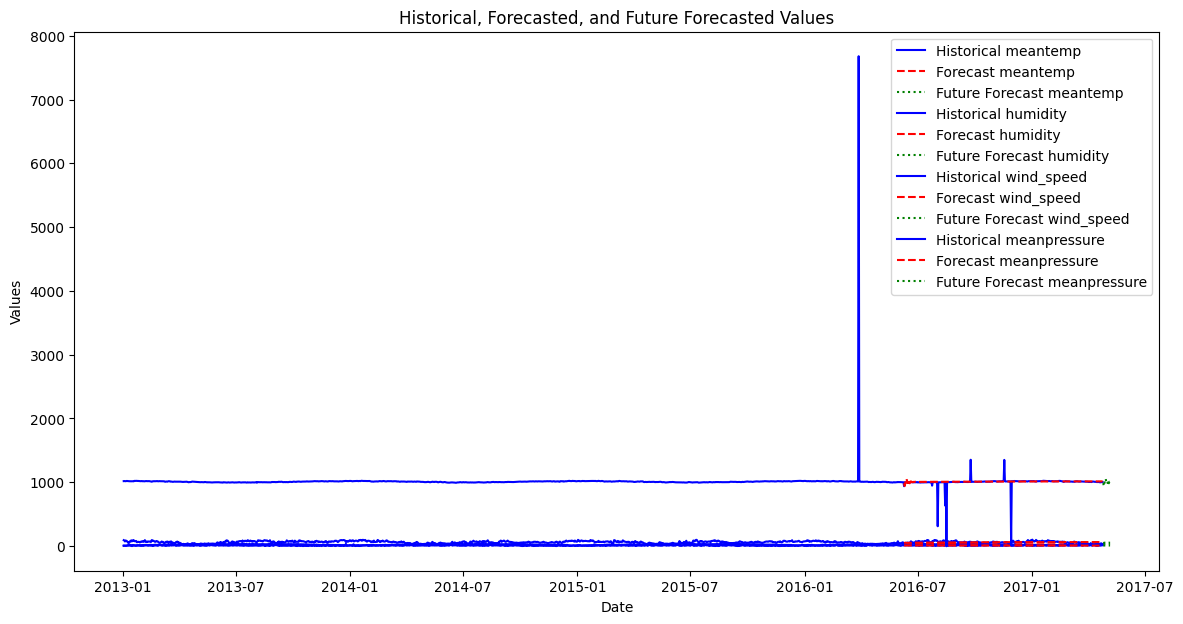

In [36]:

# Optional: Plot future forecasts
plt.figure(figsize=(14, 7))
for column in train_df.columns:
    plt.plot(df.index, df[column], label=f'Historical {column}', color='blue')
    plt.plot(forecast_df_varma.index, forecast_df_varma[column], label=f'Forecast {column}', color='red', linestyle='--')
    plt.plot(future_forecast_df.index, future_forecast_df[column], label=f'Future Forecast {column}', color='green', linestyle=':')

plt.title('Historical, Forecasted, and Future Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [37]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
2013-01-06,7.000000,82.800000,1.480000,1018.000000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


#VARMA with Exogenous Regressors (VARMAX)

**Theory:** Extends VARMA by including external regressors. It models multiple time series with both AR and MA components along with additional explanatory variables.

**Equation:** Extends VARMA to include exogenous variables:

$$
\mathbf{X}_t = \mathbf{c} + \mathbf{A}_1 \mathbf{X}_{t-1} + \cdots + \mathbf{A}_p \mathbf{X}_{t-p} + \mathbf{B}_1 \mathbf{\epsilon}_{t-1} + \cdots + \mathbf{B}_q \mathbf{\epsilon}_{t-q} + \mathbf{F}_t
$$

**Parameters:**

- **$\mathbf{A}_i$**: AR coefficient matrices  
- **$\mathbf{B}_i$**: MA coefficient matrices  
- **$p$**: AR order  
- **$q$**: MA order  
- **$\mathbf{F}_t$**: Exogenous variables


In [38]:
df['saturation'] = df['meantemp'] * 0.02

In [39]:
df['saturation'].shape

(1574,)

In [40]:
df['saturation'].isna().sum()

0

In [41]:
adfuller_test(df['saturation'], name= 'saturation')

Results of Dickey-Fuller Test for saturation:
ADF Test Statistic: -2.386594132462506
p-value: 0.14555591945343888
#Lags Used: 10
Number of Observations Used: 1563
The series 'saturation' is likely non-stationary.


In [42]:
df


,meantemp,humidity,wind_speed,meanpressure,saturation
date,,,,,
2013-01-02,7.400000,92.000000,2.980000,1017.800000,0.148000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,0.143333
2013-01-04,8.666667,71.333333,1.233333,1017.166667,0.173333
2013-01-05,6.000000,86.833333,3.700000,1016.500000,0.120000
2013-01-06,7.000000,82.800000,1.480000,1018.000000,0.140000
...,...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000,0.690000
2017-04-21,34.250000,39.375000,6.962500,999.875000,0.685000
2017-04-22,32.900000,40.900000,8.890000,1001.600000,0.658000


In [43]:
train_df=df[:-320]
test_df=df[-320:]
print(train_df.shape)
print(test_df.shape)
print(train_df.tail())
print(test_df.head())

(1254, 5)
(320, 5)
             meantemp   humidity  wind_speed  meanpressure  saturation
date                                                                  
2016-06-04  38.200000  42.066667    3.206667   1001.866667    0.764000
2016-06-05  36.166667  51.750000    8.500000   1002.833333    0.723333
2016-06-06  35.428571  45.714286   11.000000   1001.571429    0.708571
2016-06-07  34.625000  59.187500   21.306250   1002.062500    0.692500
2016-06-08  36.071429  44.642857    8.485714    999.214286    0.721429
             meantemp   humidity  wind_speed  meanpressure  saturation
date                                                                  
2016-06-09  35.733333  43.733333     9.26000    938.066667    0.714667
2016-06-10  36.133333  41.866667    10.08125    998.250000    0.722667
2016-06-11  33.437500  49.937500     8.81250    999.000000    0.668750
2016-06-12  35.500000  37.125000     9.16250    998.812500    0.710000
2016-06-13  36.000000  43.312500    12.85000    998.187500

In [44]:
endog_train = train_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
exog_train = train_df[['saturation']]

In [45]:
endog_test = test_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
exog_test = test_df[['saturation']]

In [46]:
varmax_model = VARMAX(endog_train, exog=exog_train, order=(11, 3),enforce_stationarity= True)
varmax_results = model.fit()

In [47]:
print(varmax_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Aug, 2024
Time:                     04:53:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.7463
Nobs:                     1252.00    HQIC:                   18.6951
Log likelihood:          -18769.9    FPE:                1.27589e+08
AIC:                      18.6643    Det(Omega_mle):     1.25571e+08
--------------------------------------------------------------------
Results for equation meantemp
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.026087         0.046899            0.556           0.578
L1.meantemp            -0.110249         0.036386           -3.030           0.002
L1.humidity             0.010329         0.007530

In [48]:
# exog_forecast = exog_test.copy()
# forecast = varmax_results.get_forecast(steps=len(test_df))
# forecast_mean = forecast.predicted_mean